In [8]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D #This is for 3d scatter plots.
import math
import random
import os
import scipy
from matplotlib.pyplot import imread
from PIL import Image
np.random.seed(13579201)

(133632, 90)


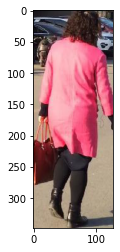

In [9]:
width = 128
height = 348
dimension = (height, width, 3)
images = []
original_images = []
filename = []
for file in os.listdir("./gallery"):
    if file.endswith(".jpg"):
        im = imread("./gallery/" + file)
        original_images.append(im)
        im = im.flatten() # flatten im into a vector
        images.append(im) 
        filename.append(file)
original_images = np.array(original_images)
A_pp = np.stack(images).T # build a matrix where each column is a flattened image
print(A_pp.shape)
plt.imshow(A_pp[:, 0].reshape(dimension))
plt.show()

In [10]:
# Preprocess, standarize the data
def preprocess(A_pp):
    mu = np.mean(A_pp,axis=1)
    Q_norms0 = []
    A0 = []
    Q = []
    for i in range(A_pp.shape[0]):
        Q_i = A_pp[i,:]-mu[i]
        Q.append(Q_i)
        Q_n_i = np.linalg.norm(Q_i,ord=np.inf)
        Q_norms0.append(Q_n_i)
        if Q_n_i!=0:
            A0.append(Q_i/Q_n_i)
        else:
            A0.append(Q_i/1)

    Q_norms = np.array(Q_norms0)
    A = np.array(A0)
    return A, Q_norms, mu

A, Q_norms, A_means = preprocess(A_pp)
print(A)
print(Q_norms)
print(A_means)

[[-0.1718896   0.10285963 -0.04292567 ... -0.22235375 -0.25599651
  -0.30646066]
 [-0.18495298  0.11410658 -0.06081505 ... -0.20752351 -0.33166144
  -0.30909091]
 [-0.17867166  0.18054256 -0.01028999 ... -0.17305893 -0.42563143
  -0.31337699]
 ...
 [ 0.2266803  -0.50166113  0.33401482 ...  0.53335037 -0.60899566
  -0.50166113]
 [ 0.19397634 -0.4756185   0.27465041 ...  0.50860523 -0.61276443
  -0.49982072]
 [ 0.0192147  -0.25647452  0.08604845 ...  0.40350877 -0.63241437
  -0.5154553 ]]
[178.34444444 177.22222222 178.16666667 ... 130.43333333 123.95555556
 119.7       ]
[ 70.65555556  71.77777778  76.83333333 ... 140.43333333 135.95555556
 130.7       ]


In [11]:
# Find eigenvalues and eigenvectors, for high dimensional data
# calculate eigenvalues and eigenvectors of A.T@A instead of computing directly
def eigen_ped(A):
    COVM = np.dot(A.T,A)
    print(COVM.shape)
    D0,F0 = np.linalg.eigh(COVM)
    idx = D0.argsort()[::-1] 
    D1 = D0[idx]
    F1 = F0[:,idx] # Sort the eigenvectors according to "direction of greatest variance"
    F2 = np.dot(A,F1)
    F3 = F2.astype(np.float64)
    F4 = np.zeros_like(F3)
    for i in range(F3.shape[1]):
        F4[:,i] = F3[:,i]/np.linalg.norm(F3[:,i])
    F4.astype(np.float64)    
    D = np.zeros(A.shape[0])
    for i in range(D1.shape[0]):
        D[i]=D1[i]
    return F4, D



F, D = eigen_ped(A)
F_real = np.real(F)
print('Orthogonality Check (should be close to 0): ', F_real[:, 0].T@F_real[:, 1])
print('Unit Vector Check: ', math.isclose(np.linalg.norm(F_real[:,0]), 1))
print(F.shape) # Should be (133632, 90)
print(D.shape) # Should be (133362)

(90, 90)
Orthogonality Check (should be close to 0):  1.3877787807814457e-16
Unit Vector Check:  True
(133632, 90)
(133632,)


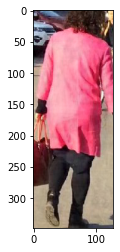

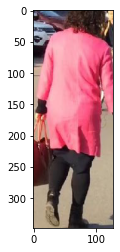

In [12]:
# Reconstruct standarized picture vector
def reconstruct_image(Img, F, Q_norms, A_means):
    im0 = np.dot(Img,F)
    im1 = np.dot(im0,F.T)
    im2 = im1*Q_norms+A_means
    im3 = im2.astype(int)
    im3 = np.clip(im3,0,255)
    im = im3.reshape(dimension)
    return im


Idx = 1
Img = A[:, Idx]
R = reconstruct_image(Img, F, Q_norms, A_means)
plt.imshow(R)
plt.show()
R = A_pp[:, Idx].reshape(dimension)
plt.imshow(R)
plt.show()
# Two images should look identical

Variance Captured: 78 %
Compressed Image: 


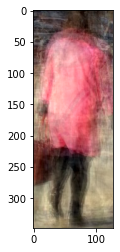

Original Image


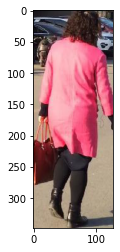

In [13]:
# use PCA to reduce the dimensionality of data
def reduce_dimensionality(image_vector, k, F, D, A_means, Q_norms):
    D1 = D[0:k]
    F1 = np.zeros_like(F)
    F1[:,:k] = F[:,:k]    
    img2 = (image_vector-A_means)/Q_norms   
    compressed = np.dot(F1.T,img2) # coordinates 
    compressed_image = np.dot(compressed,F1.T)
    p = np.sum(D1)/np.sum(D) # percentage of variance captured by the k eigenvectors
    return compressed_image, p

# Display
Idx = 0
compressed_image, p = reduce_dimensionality(A_pp[:, Idx], 30, F, D, A_means, Q_norms)
print('Variance Captured:', int(p * 100), '%')

R_c = reconstruct_image(compressed_image, F, Q_norms, A_means)
print('Compressed Image: ')
plt.imshow(R_c)
plt.show()
Img = A[:, Idx]
R_o = A_pp[:, Idx].reshape(dimension)
print('Original Image')
plt.imshow(R_o)
plt.show()

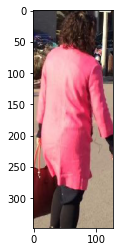

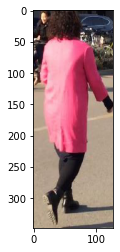

In [14]:
# Use PCA projection to search for a nearest-neighbour over all the 90 persons. 
# Returns the index of the nearest image
def the_nearest_image(image_vector, A_pp, k, F, D, A_means, Q_norms):
    imv = reduce_dimensionality(image_vector, k, F, D, A_means, Q_norms)[0]
    dist = np.zeros(A_pp.shape[1])
    for i in range(A_pp.shape[1]):
        compressed_image = reduce_dimensionality(A_pp[:, i], k, F, D, A_means, Q_norms)[0]
        dist[i]=np.linalg.norm(compressed_image-imv,ord=2)
    idx = np.argmin(dist)
    return idx
    
im2 = imread("./query/0001_c5_0022.jpg")
im2 = im2.flatten()
idx = the_nearest_image(im2, A_pp, 30, F, D, A_means, Q_norms) # k used to be 30

plt.imshow(im2.reshape(dimension))
plt.show()
plt.imshow(A_pp[:, idx].reshape(dimension))
plt.show()